In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np

In [3]:
# Set the device to be used for computation
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [4]:
#Sets the batch size used for training or inference.
batch_size = 32

In [5]:
# Define the transformation pipeline for the dataset
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert image to tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize image pixel values
])

# Load the training dataset
trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                      download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

# Load the testing dataset
testset = torchvision.datasets.MNIST(root='./data', train=False,
                                     download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

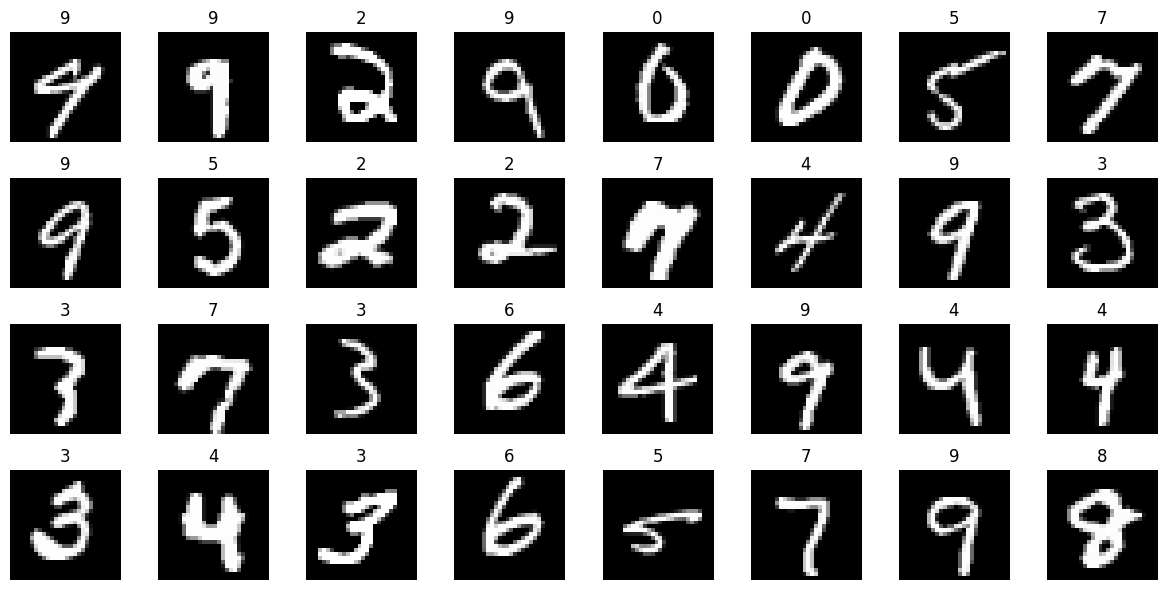

In [6]:
# Get a batch of images and labels from the trainloader
images, labels = next(iter(trainloader))

# Plot the images
fig, axes = plt.subplots(nrows=4, ncols=8, figsize=(12, 6))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(np.transpose(images[i], (1, 2, 0)), cmap='gray')
    ax.axis('off')
    ax.set_title(str(labels[i].item()))

plt.tight_layout()
plt.show()

In [7]:
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.flatten = nn.Flatten()  # Flatten the input tensor
        self.fc1 = nn.Linear(28*28, 128)  # Fully connected layer 1
        self.relu1 = nn.ReLU()  # ReLU activation function
        self.fc2 = nn.Linear(128, 128)  # Fully connected layer 2
        self.relu2 = nn.ReLU()  # ReLU activation function
        self.fc3 = nn.Linear(128, 10)  # Fully connected layer 3
        self.softmax = nn.Softmax(dim=1)  # Softmax activation function

    def forward(self, x):
        x = self.flatten(x)  # Flatten the input tensor
        x = self.fc1(x)  # Pass through fully connected layer 1
        x = self.relu1(x)  # Apply ReLU activation
        x = self.fc2(x)  # Pass through fully connected layer 2
        x = self.relu2(x)  # Apply ReLU activation
        x = self.fc3(x)  # Pass through fully connected layer 3
        x = self.softmax(x)  # Apply softmax activation
        return x

model = MyModel()  # Create an instance of MyModel

In [8]:
# Set the loss function
criterion = nn.CrossEntropyLoss()

# Set the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [9]:
# Set the number of epochs
num_epochs = 10

# Move the model to the device
model.to(device)

# Set the model in training mode
model.train()

# Training loop
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, (images, labels) in enumerate(trainloader):
        # Move the images and labels to the device
        images = images.to(device)
        labels = labels.to(device)
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(images)
        
        # Compute the loss
        loss = criterion(outputs, labels)
        
        # Backward pass
        loss.backward()
        
        # Update the weights
        optimizer.step()
        
        # Update the running loss
        running_loss += loss.item()
        
        # Print the loss every 1000 mini-batches
        if (i+1) % 1000 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(trainloader)}], Loss: {running_loss/1000:.4f}')
            running_loss = 0.0

print('Training finished.')

Epoch [1/10], Step [1000/1875], Loss: 1.6603
Epoch [2/10], Step [1000/1875], Loss: 1.5441
Epoch [3/10], Step [1000/1875], Loss: 1.5249
Epoch [4/10], Step [1000/1875], Loss: 1.5182
Epoch [5/10], Step [1000/1875], Loss: 1.5139
Epoch [6/10], Step [1000/1875], Loss: 1.5088
Epoch [7/10], Step [1000/1875], Loss: 1.5088
Epoch [8/10], Step [1000/1875], Loss: 1.5057
Epoch [9/10], Step [1000/1875], Loss: 1.5051
Epoch [10/10], Step [1000/1875], Loss: 1.5059
Training finished.


Average accuracy:  0.9571685303514377


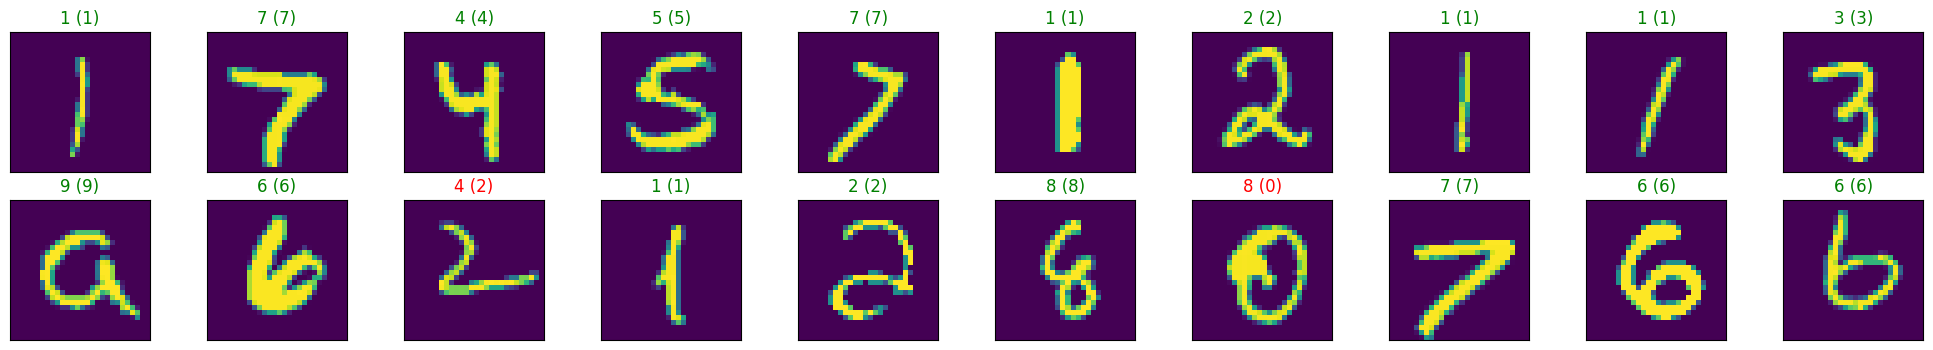

In [10]:
import random

# Set the model in evaluation mode
model.eval()

# Move the model to the device
model.to(device)

# Convert the test loader to a list
testloader_list = list(iter(testloader))

# Initialize the total accuracy
total_accuracy = 0

# Iterate over all batches
for images, labels in testloader_list:
    # Move the images and labels to the device
    images = images.to(device)
    labels = labels.to(device)

    # Forward pass
    outputs = model(images)

    # Get the predicted labels
    _, predicted = torch.max(outputs.data, 1)

    # Calculate the accuracy
    accuracy = (predicted == labels).sum().item() / labels.size(0)
    total_accuracy += accuracy

# Calculate the average accuracy
average_accuracy = total_accuracy / len(testloader_list)
print("Average accuracy: ", average_accuracy)

# Get a random batch of test data for display
images, labels = random.choice(testloader_list)

# Move the images and labels to the device
images = images.to(device)
labels = labels.to(device)

# Forward pass
outputs = model(images)

# Get the predicted labels
_, predicted = torch.max(outputs.data, 1)

# Move the images and labels back to the CPU for plotting
images = images.cpu()
predicted = predicted.cpu()

# Plot the images and their labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title("{} ({})".format(str(predicted[idx].item()), str(labels[idx].item())),
                 color=("green" if predicted[idx]==labels[idx] else "red"))